In [38]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torchvision import transforms 
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import imageio

**explore dataset**

In [2]:
IMG_SIZE = 64
BATCH_SIZE = 128

def load_data_transform():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1] 
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
    ]
    data_transform = transforms.Compose(data_transforms)
    train = torchvision.datasets.StanfordCars(root=".", download=True, 
                                         transform=data_transform)

    test = torchvision.datasets.StanfordCars(root=".", download=True, 
                                         transform=data_transform, split='test')

    return train,test

def show_tensor_image(image):
    image
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

train,test = load_data_transform()

  0%|          | 0/330960 [00:00<?, ?it/s]

Extracting stanford_cars/car_devkit.tgz to stanford_cars


  0%|          | 0/979269282 [00:00<?, ?it/s]

Extracting stanford_cars/cars_train.tgz to stanford_cars
Using downloaded and verified file: stanford_cars/car_devkit.tgz
Extracting stanford_cars/car_devkit.tgz to stanford_cars


  0%|          | 0/977350468 [00:00<?, ?it/s]

Extracting stanford_cars/cars_test.tgz to stanford_cars


  0%|          | 0/185758 [00:00<?, ?it/s]

In [3]:
train_dataloader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

**forward process: noise scheduler**

In [4]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
beta_0 = 2e-4
beta_t = 1e-3
timestep = 200

def _torch_posterior_sample(x_0, t):
    beta = torch.linspace(beta_0, beta_t, timestep).to(DEVICE)
    alpha = 1 - beta
    cum_prod_alpha = torch.cumprod(alpha, dim = 0)

    #Reparameterization trick
    eps = torch.randn_like(x_0).to(DEVICE) #get eps from normal distribution
    x_t = torch.sqrt(cum_prod_alpha[t]) * x_0.to(DEVICE) + torch.sqrt(1 - cum_prod_alpha[t]) * eps
    return x_t.to(DEVICE),eps

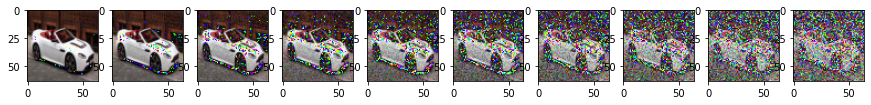

In [5]:
image = next(iter(train_dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
T = 100

for idx in range(0, T, num_images):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images, idx//num_images + 1)
    image, noise = _torch_posterior_sample(image, t)
    show_tensor_image(image.cpu())

**reverse process**
- We use a simple form of a UNet for to predict the noise in the image
- The input is a noisy image, the ouput the noise in the image
- Because the parameters are shared accross time, we need to tell the network in which timestep we are
- The Timestep is encoded by the transformer Sinusoidal Embedding
- We output one single value (mean), because the variance is fixed


In [31]:
#simple U-net architecture

class Block(nn.Module):
    def __init__(self,in_chan,out_chan,time_emb_dim,up=False):
        super(Block,self).__init__()
        self.time_mlp = nn.Linear(time_emb_dim,out_chan)
        if up:
            self.conv1 = nn.Conv2d(2*in_chan,out_chan,3,padding=1)
            self.transform = nn.ConvTranspose2d(out_chan,out_chan,4,2,1)
        else:
            self.conv1 = nn.Conv2d(in_chan,out_chan,3,padding=1)
            self.transform = nn.Conv2d(out_chan, out_chan, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_chan, out_chan, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_chan)
        self.bnorm2 = nn.BatchNorm2d(out_chan)
        self.relu  = nn.ReLU()

        self.firstConv = nn.Sequential(
            self.conv1,
            self.relu,
            self.bnorm1,
        )

        self.secondConv = nn.Sequential(
            self.conv2,
            self.relu,
            self.bnorm2
        )

    def forward(self,x,t):
        #first conv
        h = self.firstConv(x)
        #time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.secondConv(h)
        # Down or Upsample
        return self.transform(h)

class TimeEmbedding(nn.Module):
    def __init__(self,dim):
        super(TimeEmbedding,self).__init__()
        self.dim = dim

    def forward(self,time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class SimpleUnet(nn.Module):
    def __init__(self):
        super(SimpleUnet,self).__init__()
        image_channels = 1
        down_channels = (64, 128, 256)
        up_channels = (256, 128, 64)
        out_dim = 1 
        time_emb_dim = 32

        #time_embedding_dim
        self.time_mlp = nn.Sequential(
            TimeEmbedding(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels,down_channels[0],3,padding = 1)

        # DownSampling
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])

        #upSampling
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        
        self.output = nn.Conv2d(up_channels[-1], 1, out_dim)
    
    def forward(self, x, timestep):
        t = self.time_mlp(timestep)

        x = self.conv0(x)
        residual_inputs = []
        for down in self.downs:
           x = down(x,t)
           residual_inputs.append(x) 
        
        for up in self.ups:
           residual_x = residual_inputs.pop()
           x = torch.cat((x, residual_x), dim=1)

           x = up(x,t)
        
        return self.output(x)

In [ ]:
model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

**loss**

In [8]:
def get_loss(model, x_0, t):
    x_noisy, noise = _torch_posterior_sample(x_0, t)
    noise_pred = model(x_noisy, t)
    return F.l2_loss(noise, noise_pred)

**Diffusion Model**

In [29]:
class Diffusion(nn.Module):
    def __init__(self, beta_0, beta_t, time_step, denoise_net):
        super(Diffusion,self).__init__()
        self.denoise_net = denoise_net
        beta = torch.linspace(beta_0, beta_t, time_step)
        self.alpha = 1.0 - beta
        self.cum_alpha = torch.cumprod(self.alpha, dim = 0)
    
    def _posterior_sample(self, x_0, t):
        batch = x_0.shape[0]
        eps = torch.randn_like(x_0).to('cuda')
        mean = (self.cum_alpha[t].view(batch, 1,1,1).to('cuda'))**0.5 * x_0
        std = (1.0-self.cum_alpha[t].view(batch,1,1,1)).to('cuda')**0.5 * eps
        return mean + std, eps
    
    @torch.no_grad()
    def _reverse(self,noise,t):
        z = torch.randn_like(noise) if t >= 1 else 0
        time = torch.Tensor([t]).long().to('cuda')
        eps_theta = self.denoise_net(noise, time)
        eps_coff = (1.0-self.alpha[t]) / ((1-self.cum_alpha[t])**0.5)

        x_prev = (1.0 / (self.alpha[t] ** 0.5)) * (noise - eps_coff * eps_theta) + z * ((1-self.alpha[t])**0.5)
        return x_prev

    @torch.no_grad()
    def _sampling(self,x_0,noise_T=None):
        if noise_T is not None:
           image = noise_T
        else:
           image = torch.randn_like(x_0)

        tracks = [image]
        t = len(self.alpha) - 1
        while t >= 0:
            image = self._reverse(image,t)
            tracks.append(image)
            t = t - 1
        
        return image, tracks
    
    def forward(self, x_0, t):
        x_t, eps = self._posterior_sample(x_0, t)
        eps_theta = self.denoise_net(x_t,t)

        return eps,eps_theta

**Training**

In [15]:
epochs = 200
lr = 2e-2
beta_0 = 0.0001
beta_t = 0.02
time_steps = 300

In [ ]:
unet_model = SimpleUnet().to(DEVICE)
diffusion_model = Diffusion(beta_0,beta_t,time_steps,unet_model)
dataset = torchvision.datasets.MNIST('.', download = True, train=True, transform = torchvision.transforms.ToTensor())
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 500, shuffle = True)

optimizer = torch.optim.Adam([p for p in diffusion_model.parameters() if p.requires_grad == True], lr=lr, betas = (0.9, 0.999))
losses = []
for epoch in range(epochs):
    diffusion_model.train()
    for dataset,_ in tqdm(dataloader):
        optimizer.zero_grad()

        x_0 = dataset[0].to(DEVICE)
        t = torch.randint(0, time_steps, (x_0.shape[0], )).to(DEVICE)
        eps_theta, eps = diffusion_model(x_0, t)

        loss = nn.functional.l1_loss(eps, eps_theta, reduction="mean")

        loss.backward()
        nn.utils.clip_grad_norm_(diffusion_model.parameters(), 1.)
        optimizer.step()        
        losses.append(loss.item())
    print("\nLoss after {} = {}".format(epoch, loss.item()))
    if epoch % 10 == 0:
       noise = torch.randn(16,1,28,28).to(DEVICE)
       gen_img, tracks = diffusion_model._sampling(x_0, noise_T = noise)
       tracks.extend([gen_img]*100)
       toImg = torchvision.transforms.ToPILImage()
      
       images = [torchvision.utils.make_grid(x, nrow = 4) for x in tracks] # list of grids
       gif_src = [np.array(toImg(img)) for img in images]

       imageio.mimsave('\content{}.gif'.format(epoch), gif_src, format = 'GIF', fps=10)

100%|██████████| 120/120 [00:06<00:00, 18.43it/s]



Loss after 0 = 0.2654186487197876


100%|██████████| 120/120 [00:07<00:00, 16.68it/s]



Loss after 1 = 0.27541691064834595


100%|██████████| 120/120 [00:06<00:00, 18.61it/s]



Loss after 2 = 0.1867840737104416


100%|██████████| 120/120 [00:06<00:00, 18.70it/s]



Loss after 3 = 0.21156960725784302


100%|██████████| 120/120 [00:06<00:00, 18.65it/s]



Loss after 4 = 0.16627171635627747


100%|██████████| 120/120 [00:06<00:00, 18.59it/s]



Loss after 5 = 0.24284565448760986


100%|██████████| 120/120 [00:06<00:00, 18.02it/s]



Loss after 6 = 0.1405770182609558


100%|██████████| 120/120 [00:06<00:00, 18.39it/s]



Loss after 7 = 0.17688283324241638


100%|██████████| 120/120 [00:07<00:00, 15.65it/s]



Loss after 8 = 0.21572694182395935


100%|██████████| 120/120 [00:06<00:00, 18.37it/s]



Loss after 9 = 0.1734076291322708


100%|██████████| 120/120 [00:07<00:00, 15.19it/s]



Loss after 10 = 0.19440241158008575


100%|██████████| 120/120 [00:06<00:00, 18.11it/s]



Loss after 11 = 0.23596148192882538


100%|██████████| 120/120 [00:06<00:00, 18.22it/s]



Loss after 12 = 0.13485661149024963


100%|██████████| 120/120 [00:06<00:00, 18.08it/s]



Loss after 13 = 0.19302725791931152


100%|██████████| 120/120 [00:06<00:00, 18.06it/s]



Loss after 14 = 0.2422148585319519


100%|██████████| 120/120 [00:07<00:00, 16.26it/s]



Loss after 15 = 0.19447456300258636


100%|██████████| 120/120 [00:06<00:00, 18.26it/s]



Loss after 16 = 0.11922512948513031


100%|██████████| 120/120 [00:06<00:00, 18.36it/s]



Loss after 17 = 0.18370014429092407


100%|██████████| 120/120 [00:06<00:00, 18.45it/s]



Loss after 18 = 0.14793135225772858


100%|██████████| 120/120 [00:06<00:00, 18.29it/s]



Loss after 19 = 0.2297065407037735


100%|██████████| 120/120 [00:06<00:00, 18.39it/s]



Loss after 20 = 0.18286222219467163


100%|██████████| 120/120 [00:06<00:00, 18.52it/s]



Loss after 21 = 0.23610667884349823


100%|██████████| 120/120 [00:06<00:00, 18.27it/s]



Loss after 22 = 0.27341118454933167


100%|██████████| 120/120 [00:06<00:00, 18.06it/s]



Loss after 23 = 0.1745932549238205


100%|██████████| 120/120 [00:06<00:00, 18.48it/s]



Loss after 24 = 0.18876254558563232


100%|██████████| 120/120 [00:06<00:00, 18.47it/s]



Loss after 25 = 0.15890808403491974


100%|██████████| 120/120 [00:06<00:00, 18.50it/s]



Loss after 26 = 0.18497075140476227


100%|██████████| 120/120 [00:06<00:00, 18.40it/s]



Loss after 27 = 0.2149619162082672


100%|██████████| 120/120 [00:06<00:00, 18.26it/s]



Loss after 28 = 0.24864909052848816


100%|██████████| 120/120 [00:08<00:00, 14.77it/s]



Loss after 29 = 0.1325235664844513


100%|██████████| 120/120 [00:07<00:00, 17.00it/s]



Loss after 30 = 0.11900107562541962


100%|██████████| 120/120 [00:06<00:00, 18.23it/s]



Loss after 31 = 0.2241845428943634


100%|██████████| 120/120 [00:06<00:00, 18.09it/s]



Loss after 32 = 0.13558730483055115


100%|██████████| 120/120 [00:06<00:00, 18.23it/s]



Loss after 33 = 0.1930123269557953


100%|██████████| 120/120 [00:06<00:00, 18.44it/s]



Loss after 34 = 0.1439843475818634


100%|██████████| 120/120 [00:06<00:00, 18.52it/s]



Loss after 35 = 0.17819085717201233


100%|██████████| 120/120 [00:06<00:00, 18.41it/s]



Loss after 36 = 0.21593786776065826


100%|██████████| 120/120 [00:06<00:00, 18.10it/s]



Loss after 37 = 0.2422783523797989


100%|██████████| 120/120 [00:06<00:00, 18.46it/s]



Loss after 38 = 0.16892419755458832


100%|██████████| 120/120 [00:06<00:00, 18.52it/s]



Loss after 39 = 0.21760471165180206


100%|██████████| 120/120 [00:06<00:00, 18.45it/s]



Loss after 40 = 0.10293735563755035


100%|██████████| 120/120 [00:06<00:00, 18.36it/s]



Loss after 41 = 0.1885698288679123


100%|██████████| 120/120 [00:06<00:00, 18.46it/s]



Loss after 42 = 0.13521717488765717


100%|██████████| 120/120 [00:06<00:00, 18.35it/s]



Loss after 43 = 0.12439852207899094


100%|██████████| 120/120 [00:07<00:00, 16.84it/s]



Loss after 44 = 0.2339261770248413


100%|██████████| 120/120 [00:06<00:00, 18.41it/s]



Loss after 45 = 0.14494070410728455


100%|██████████| 120/120 [00:06<00:00, 17.99it/s]



Loss after 46 = 0.10185769945383072


100%|██████████| 120/120 [00:06<00:00, 18.27it/s]



Loss after 47 = 0.2312273383140564


100%|██████████| 120/120 [00:06<00:00, 18.38it/s]



Loss after 48 = 0.2191455364227295


100%|██████████| 120/120 [00:06<00:00, 18.26it/s]



Loss after 49 = 0.17840242385864258


100%|██████████| 120/120 [00:06<00:00, 18.03it/s]



Loss after 50 = 0.2393566220998764


100%|██████████| 120/120 [00:06<00:00, 18.38it/s]



Loss after 51 = 0.15447865426540375


100%|██████████| 120/120 [00:06<00:00, 18.45it/s]



Loss after 52 = 0.19335545599460602


100%|██████████| 120/120 [00:06<00:00, 18.05it/s]



Loss after 53 = 0.11856238543987274


 77%|███████▋  | 92/120 [00:05<00:01, 17.52it/s]